# Compare SDP and ASDP knockoffs

In [3]:
using Revise
using Knockoffs
using Test
using LinearAlgebra
using Random
using StatsBase
using Statistics
using Distributions
using ToeplitzMatrices
using SnpArrays
using Plots
using MendelIHT: simulate_random_snparray
gr(fmt=:png);

Our model is

$$X_{p \times 1} \sim N(\mathbf{0}_p, \Sigma)$$
where
$$
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & 1 & & ... & \rho^{p-1}\\
    \vdots & & & 1 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}
$$
Given $n$ iid samples from the above distribution, we will generate knockoffs according to 
$$(X, \tilde{X}) \sim N
\left(0, \ 
\begin{pmatrix}
    \Sigma & \Sigma - diag(s)\\
    \Sigma - diag(s) & \Sigma
\end{pmatrix}
\right)
$$
where $s$ is solved so that $0 \le s_j \forall j$ and $G$ is PSD (i.e. $2Σ - diag(s)$ is PSD)

## SDP vs ASDP

In [37]:
# simulate data
Random.seed!(2022)
n = 100
p = 500
ρ = 0.4
Sigma = Matrix(SymmetricToeplitz(ρ.^(0:(p-1))))
L = cholesky(Sigma).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)
true_mu = zeros(p)

# generate SDP knockoffs (using true and estimated covariance)
@time sdp_true = modelX_gaussian_knockoffs(X, :sdp, true_mu, Sigma); 
@time sdp_approx = modelX_gaussian_knockoffs(X, :sdp);

269.834199 seconds (3.06 M allocations: 5.498 GiB, 4.02% gc time)
124.881105 seconds (4.45 M allocations: 5.618 GiB, 10.05% gc time, 6.09% compilation time)


In [38]:
# generate ASDP knockoff
@time asdp = approx_modelX_gaussian_knockoffs(X, :sdp, windowsize = 99);

Approximating covariance by blocks... 100%|██████████████| Time: 0:00:05


 10.237029 seconds (27.51 M allocations: 2.366 GiB, 33.76% gc time)


In [39]:
# compare s vector (note: 3rd to last entry is different between sdp_approx and asdp)
[sdp_true.s sdp_approx.s asdp.s] 

500×3 Matrix{Float64}:
 1.0       0.807852  0.807852
 0.971429  0.850731  0.850731
 0.811429  1.09873   1.09873
 0.875429  0.90821   0.90821
 0.849829  0.960602  0.960602
 0.860069  1.03202   1.03202
 0.855973  0.967948  0.967948
 0.857611  0.777142  0.777142
 0.856956  0.915541  0.915541
 0.857218  0.900833  0.900833
 0.857113  0.756061  0.756061
 0.857155  1.23477   1.23477
 0.857138  0.870269  0.870269
 ⋮                   
 0.857155  0.862388  0.862388
 0.857113  1.0446    1.0446
 0.857218  0.636179  0.636179
 0.856956  0.709646  0.709646
 0.857611  0.911029  0.911029
 0.855973  0.922853  0.922853
 0.860069  1.01331   1.01331
 0.849829  1.1558    1.1558
 0.875429  0.98173   0.98173
 0.811429  1.01605   0.907923
 0.971429  0.915304  0.915304
 1.0       0.720507  0.720507

Check approximate solution satisfies $2\Sigma \succeq diag(s)$

In [5]:
eigmin(2*asdp.Σ - Diagonal(asdp.s)) # check PSD

0.035435992221507444

Check ASDP's solution controls FDR

In [6]:
# simulate data
Random.seed!(11)
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(50)
shuffle!(βtrue)
correct_position = findall(!iszero, βtrue)
y = X * βtrue + randn(n)

# run lasso
@time knockoff_filter = fit_lasso(y, X, asdp.X̃);

  9.721361 seconds (13.73 M allocations: 827.035 MiB, 4.26% gc time, 96.07% compilation time)


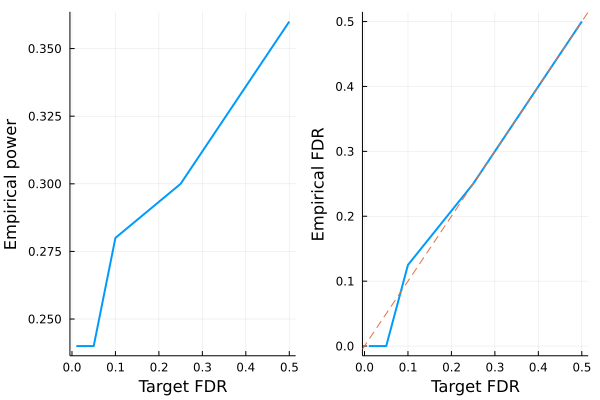

In [7]:
# plot power and FDR
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    βknockoff = knockoff_filter.βs[i]
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

## MVR vs AMVR

In [41]:
@time mvr = modelX_gaussian_knockoffs(X, :mvr, true_mu, Sigma);
@time amvr = approx_modelX_gaussian_knockoffs(X, :mvr, windowsize = 100);
@time amvr2 = approx_modelX_gaussian_knockoffs(X, :mvr, windowsize = 99);

  3.130989 seconds (61 allocations: 19.917 MiB)
  0.449399 seconds (2.40 M allocations: 192.949 MiB, 6.66% gc time)
  0.437240 seconds (2.41 M allocations: 193.514 MiB, 13.56% gc time)


In [42]:
[mvr.s amvr.s amvr2.s] # compare s vector

500×3 Matrix{Float64}:
 0.705584  0.663288  0.661015
 0.5506    0.697905  0.69608
 0.557963  0.921062  0.918219
 0.557899  0.761527  0.759815
 0.557883  0.79024   0.787992
 0.557884  0.861529  0.858912
 0.557884  0.801033  0.798751
 0.557884  0.667032  0.665561
 0.557884  0.766879  0.765007
 0.557884  0.741398  0.738973
 0.557884  0.643368  0.643104
 0.557884  1.0488    1.04573
 0.557884  0.71336   0.710989
 ⋮                   
 0.557884  0.692749  0.698797
 0.557884  0.855441  0.86373
 0.557884  0.534393  0.537774
 0.557884  0.593851  0.59589
 0.557884  0.765961  0.768008
 0.557884  0.784296  0.791352
 0.557884  0.843415  0.857498
 0.557883  0.955454  0.943184
 0.557899  0.821244  0.569699
 0.557963  0.833571  0.554396
 0.5506    0.779083  0.613877
 0.705584  0.598158  0.584132

In [43]:
isposdef(2*amvr.Σ - Diagonal(amvr.s)) # check PSD

true

## Try on PLINK BED files

In [60]:
X = simulate_random_snparray(undef, 1000, 500)  # compressed plink bed file
Xfloat = convert(Matrix{Float64}, X, center=true, scale=true) # numeric matrix

1000×500 Matrix{Float64}:
 -0.709316   0.993912  -1.18868   …  -1.2792    -0.649082   2.90303
  1.05515   -0.734631   0.246925      0.142134  -0.649082  -0.326147
 -0.709316   0.993912   0.246925     -1.2792    -0.649082  -0.326147
 -0.709316  -0.734631  -1.18868      -1.2792    -0.649082  -0.326147
  1.05515    2.72246    1.68253       1.56347   -0.649082  -0.326147
  1.05515   -0.734631   0.246925  …   0.142134   1.2161    -0.326147
 -0.709316   0.993912   0.246925      1.56347   -0.649082  -0.326147
 -0.709316  -0.734631  -1.18868      -1.2792    -0.649082  -0.326147
  1.05515    0.993912   1.68253      -1.2792    -0.649082  -0.326147
 -0.709316   0.993912   0.246925      0.142134  -0.649082  -0.326147
  1.05515   -0.734631   0.246925  …  -1.2792     3.08127   -0.326147
 -0.709316  -0.734631  -1.18868       1.56347   -0.649082  -0.326147
 -0.709316   0.993912  -1.18868       1.56347    1.2161    -0.326147
  ⋮                               ⋱                        
 -0.709316  -0.734

Check results agree on PLINK files and on numeric matrices

In [66]:
@time asdp_true = approx_modelX_gaussian_knockoffs(Xfloat, :sdp, windowsize=100);
@time asdp = approx_modelX_gaussian_knockoffs(X, :sdp, windowsize=99);
[asdp_true.s asdp.s]

Approximating covariance by blocks... 100%|██████████████| Time: 0:00:02


  2.606945 seconds (3.04 M allocations: 514.003 MiB, 6.02% gc time)


Approximating covariance by blocks... 100%|██████████████| Time: 0:00:02


  2.680756 seconds (3.04 M allocations: 508.325 MiB, 4.45% gc time)


500×2 Matrix{Float64}:
 0.98505   0.98505
 1.01102   1.01102
 1.01486   1.01486
 1.00002   1.00002
 0.96854   0.96854
 1.00017   1.00017
 1.01039   1.01039
 1.01409   1.01409
 1.03618   1.03618
 1.0019    1.0019
 0.961475  0.961475
 0.983593  0.983593
 0.999961  0.999961
 ⋮         
 0.974315  0.974315
 0.987359  0.987359
 0.973405  0.973405
 1.02672   1.02672
 0.96816   0.96816
 1.07277   1.07277
 1.01235   1.01235
 1.02888   1.02888
 0.988237  0.988237
 1.05455   1.05455
 0.977206  0.977206
 0.988524  0.988524

Is result robust to window size? For MVR, results differ very slightly. For SDP, result is completely the same

In [68]:
@time amvr_true = approx_modelX_gaussian_knockoffs(Xfloat, :mvr, windowsize=100);
@time amvr = approx_modelX_gaussian_knockoffs(X, :mvr, windowsize=95);
[amvr_true.s amvr.s]

  0.353879 seconds (2.40 M allocations: 227.182 MiB, 8.89% gc time)
  0.433040 seconds (2.43 M allocations: 230.863 MiB, 14.82% gc time)


500×2 Matrix{Float64}:
 0.98494   0.984999
 1.01092   1.01097
 1.01476   1.01481
 0.999898  0.999964
 0.968455  0.968502
 1.00005   1.00012
 1.01027   1.01034
 1.01399   1.01405
 1.03608   1.03614
 1.00181   1.00186
 0.961362  0.961427
 0.983453  0.983535
 0.999877  0.999924
 ⋮         
 0.974315  0.974207
 0.987359  0.987231
 0.973405  0.973363
 1.02672   1.02663
 0.96816   0.968049
 1.07277   1.07264
 1.01235   1.01228
 1.02888   1.02883
 0.988237  0.988165
 1.05455   1.05445
 0.977206  0.977113
 0.988524  0.988418

## Conclusion

+ Without parallelization, the approximate construction (windowsize = 100) is 10-30x faster than the full construction with $p=500$ variables.
+ The `s` vector between approximate/full construction appears quite different, but the approximate `s` vector indeed satisfies $2\Sigma \succeq diag(s)$